# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from scipy import stats
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from keras import callbacks
from keras.layers import Dense, Input, Dropout, Normalization, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
tf.random.set_seed(42)
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV

# Data Cleaning

In [ ]:
df = pd.read_csv('/content/weatherAUS.csv')

## Information about the data


In [ ]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [ ]:
number_of_rows = df.shape[0]
number_of_features = df.shape[1]
print(f'The dataset contains {number_of_rows} rows')
print(f'The dataset contains {number_of_features} columns')

The dataset contains 145460 rows
The dataset contains 23 columns


## Data Cleaning
We can now focus our attention on the data cleaning part in order to discover:
- **NaN values**
- **Outliers**
- **Multicollinearity Problem**



---



In [ ]:
for col in df.columns:
    unique_values = df[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values")

Column 'Date' has 3436 unique values
Column 'Location' has 49 unique values
Column 'MinTemp' has 390 unique values
Column 'MaxTemp' has 506 unique values
Column 'Rainfall' has 682 unique values
Column 'Evaporation' has 359 unique values
Column 'Sunshine' has 146 unique values
Column 'WindGustDir' has 17 unique values
Column 'WindGustSpeed' has 68 unique values
Column 'WindDir9am' has 17 unique values
Column 'WindDir3pm' has 17 unique values
Column 'WindSpeed9am' has 44 unique values
Column 'WindSpeed3pm' has 45 unique values
Column 'Humidity9am' has 102 unique values
Column 'Humidity3pm' has 102 unique values
Column 'Pressure9am' has 547 unique values
Column 'Pressure3pm' has 550 unique values
Column 'Cloud9am' has 11 unique values
Column 'Cloud3pm' has 11 unique values
Column 'Temp9am' has 442 unique values
Column 'Temp3pm' has 503 unique values
Column 'RainToday' has 3 unique values
Column 'RainTomorrow' has 3 unique values


In [ ]:
for col in ['RainToday', 'RainTomorrow']:
    unique_values = df[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values: {unique_values}\n")

Column 'RainToday' has 3 unique values: ['No' 'Yes' nan]

Column 'RainTomorrow' has 3 unique values: ['No' 'Yes' nan]



In [ ]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})

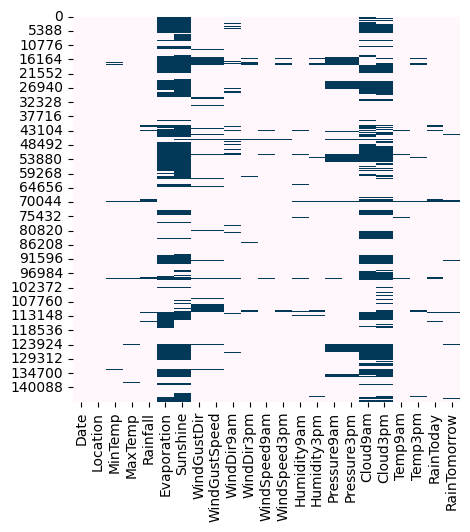

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(df.isnull(), cbar=False, cmap='PuBu')
plt.show()

In [ ]:
missing_values = df.isnull().sum()

percent_missing = df.isnull().sum()/df.shape[0]*100

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing ,
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

,missing_values,percent_missing %,data type
Date,0,0.000000,object
Location,0,0.000000,object
MinTemp,1485,1.020899,float64
MaxTemp,1261,0.866905,float64
Rainfall,3261,2.241853,float64
Evaporation,62790,43.166506,float64
Sunshine,69835,48.009762,float64
WindGustDir,10326,7.098859,object
WindGustSpeed,10263,7.055548,float64
WindDir9am,10566,7.263853,object


In [ ]:
categorical, contin=[],[]

for i in df.columns:

    if df[i].dtype == 'object':
        categorical.append(i)
    else:
        contin.append(i)

print(categorical)
print(contin)

['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


In [ ]:
for i in categorical:
    df[i].fillna(df[i].mode()[0], inplace=True)

In [ ]:
lencoders = {}
for col in df.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    df[col] = lencoders[col].fit_transform(df[col])

In [ ]:
(df[contin].isnull().sum()/len(df[contin]))

,0
MinTemp,0.010209
MaxTemp,0.008669
Rainfall,0.022419
Evaporation,0.431665
Sunshine,0.480098
WindGustSpeed,0.070555
WindSpeed9am,0.012148
WindSpeed3pm,0.021050
Humidity9am,0.018246
Humidity3pm,0.030984


In [ ]:
df = df.dropna(subset=['RainToday', 'RainTomorrow'])

In [ ]:
mice_imputer = IterativeImputer(max_iter=1000)
df.iloc[:,:] = mice_imputer.fit_transform(df)

In [ ]:
missing_values=df.isnull().sum()

percent_missing = df.isnull().sum()/df.shape[0]*100

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing ,
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

,missing_values,percent_missing %,data type
Date,0,0.0,int64
Location,0,0.0,int64
MinTemp,0,0.0,float64
MaxTemp,0,0.0,float64
Rainfall,0,0.0,float64
Evaporation,0,0.0,float64
Sunshine,0,0.0,float64
WindGustDir,0,0.0,int64
WindGustSpeed,0,0.0,float64
WindDir9am,0,0.0,int64


Let's find **outliers**

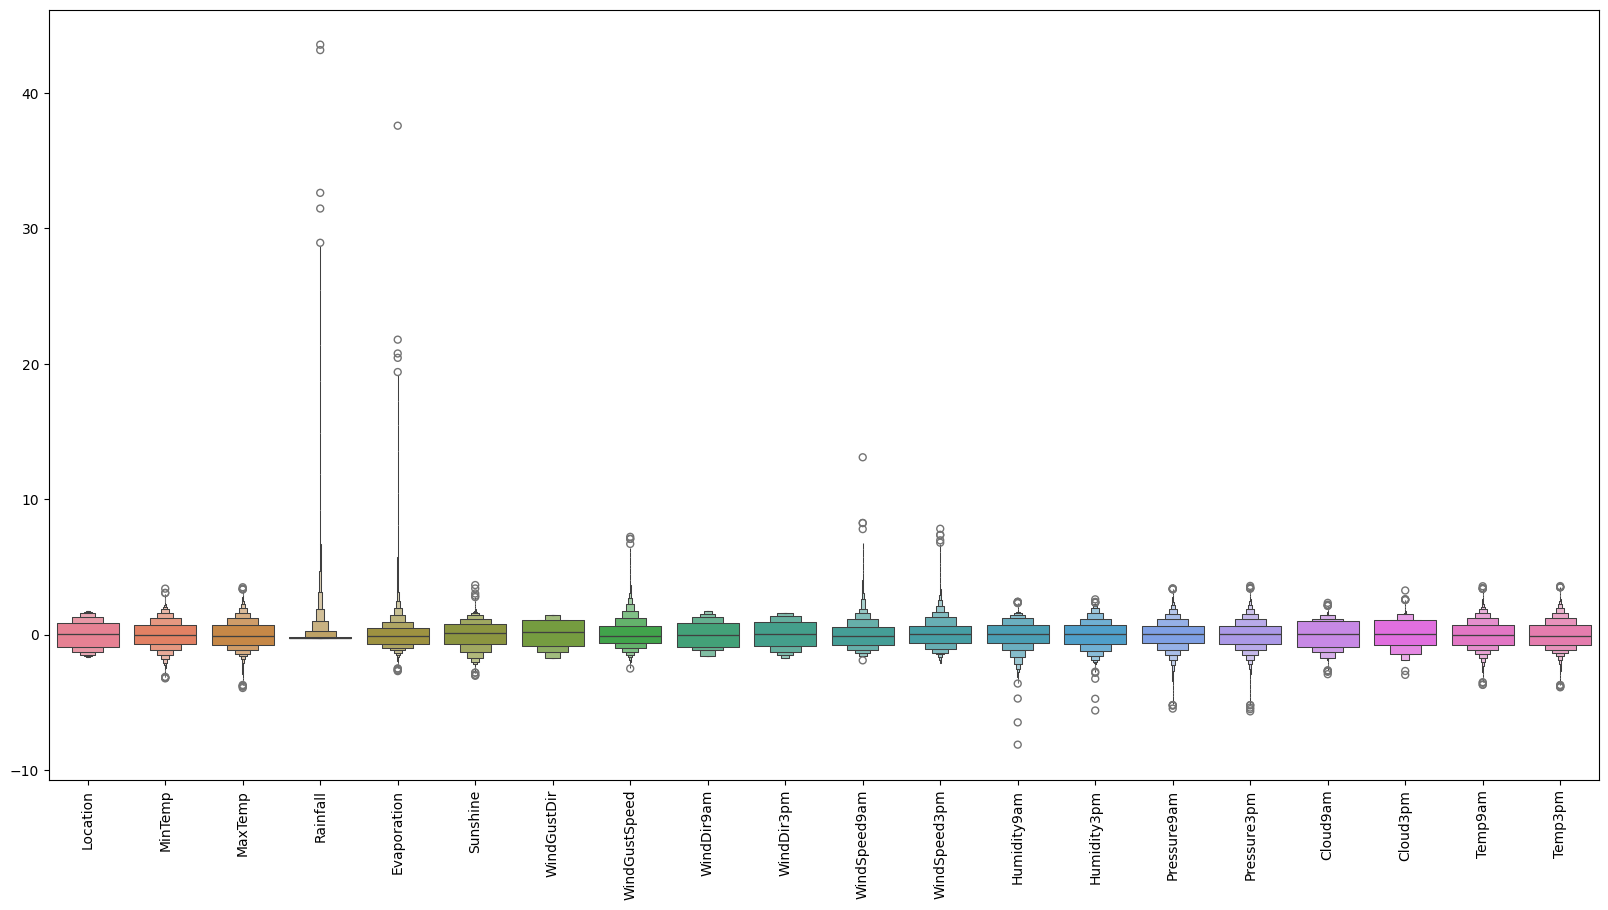

In [ ]:
features = df.drop(['RainTomorrow','RainToday','Date'], axis=1)
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)
plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

In [ ]:
def outlier_thresholds (dataframe, column, q1=0.25, q3=0.75) :
    quartile1 = dataframe[column].quantile(q1)
    quartile3 = dataframe[column].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    outliers = (dataframe[column] > up_limit) | (dataframe[column] < low_limit)
    if outliers.any():
        return True
    else:
        return False
def replace_with_thresholds (dataframe, column) :
    low_limit , up_limit = outlier_thresholds(dataframe, column)
    dataframe.loc[(dataframe[column] < low_limit), column] = low_limit
    dataframe.loc[(dataframe[column] > up_limit), column] = up_limit

In [ ]:
print('Before removing the outliers :')
for column in (df.drop(columns = ['RainTomorrow', 'RainToday', 'Date', 'Location']).columns):
    print(column, check_outlier(df, column))

Before removing the outliers :
MinTemp True
MaxTemp True
Rainfall True
Evaporation True
Sunshine True
WindGustDir False
WindGustSpeed True
WindDir9am False
WindDir3pm False
WindSpeed9am True
WindSpeed3pm True
Humidity9am True
Humidity3pm True
Pressure9am True
Pressure3pm True
Cloud9am False
Cloud3pm False
Temp9am True
Temp3pm True


In [ ]:
print('After removing the outliers :')
for column in (df.drop(columns = ['RainTomorrow', 'RainToday', 'Date', 'Location']).columns):
    replace_with_thresholds(df, column)
    print(column, check_outlier(df, column))

After removing the outliers :
MinTemp False
MaxTemp False
Rainfall False
Evaporation False
Sunshine False
WindGustDir False
WindGustSpeed False
WindDir9am False
WindDir3pm False
WindSpeed9am False
WindSpeed3pm False
Humidity9am False
Humidity3pm False
Pressure9am False
Pressure3pm False
Cloud9am False
Cloud3pm False
Temp9am False
Temp3pm False


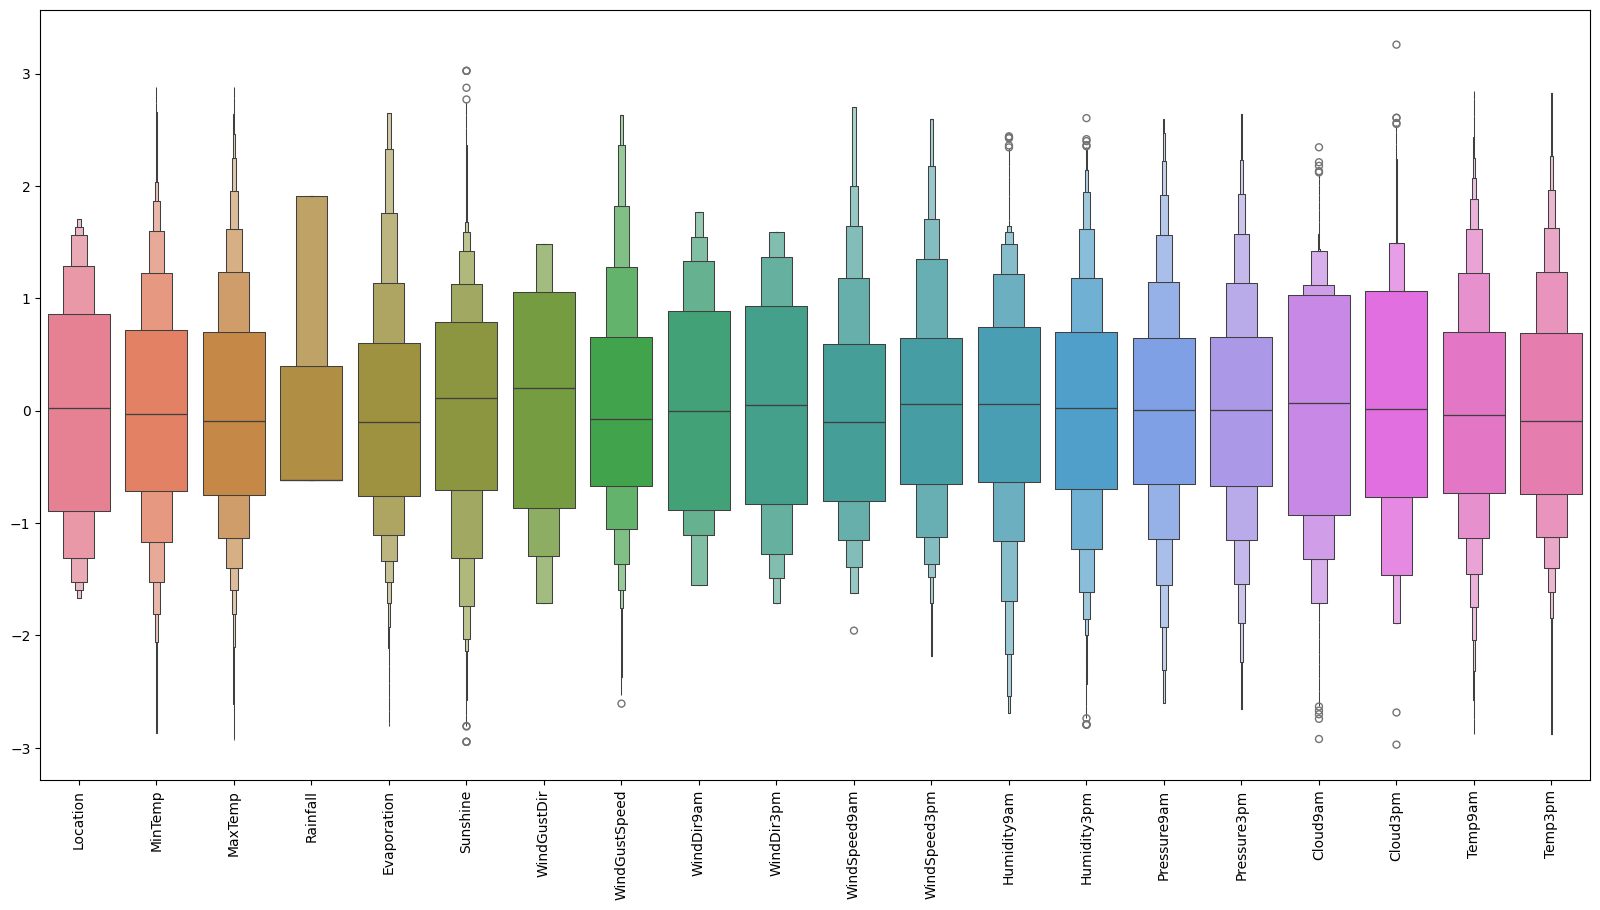

In [ ]:
features = df.drop(['RainTomorrow','RainToday','Date'], axis=1)
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)
plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df.drop(['Temp3pm', 'Pressure9am', 'Temp9am', 'Rainfall'], axis=1, inplace=True)

# Machine Learning


In [ ]:
df.drop('Date',axis = 1, inplace = True)

## Data Preprocessing

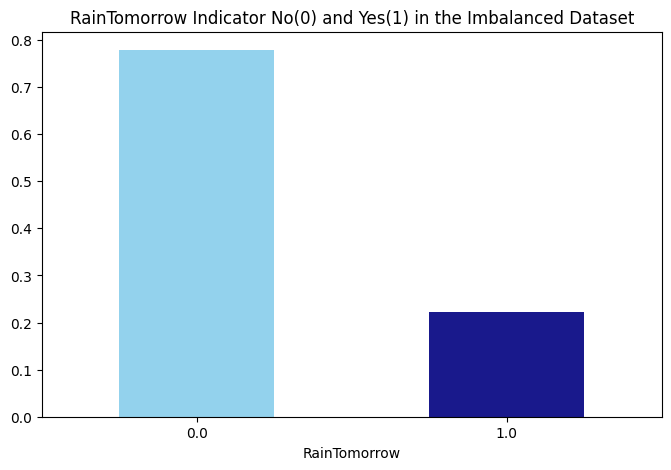

In [ ]:
fig = plt.figure(figsize = (8,5))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

In [ ]:
X = df.drop('RainTomorrow', axis = 1)
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=df['RainTomorrow'])
print('X_train size', X_train.shape)
print('y_train size', y_train.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

X_train size (105590, 17)
y_train size (105590,)
X_test size (35197, 17)
y_test size (35197,)


In [ ]:
class Model:
    def __init__(self, model, name = None, scaled = True, resample = None):
        self.model = model
        self.name = name
        self.scaled = scaled
        self.resample = resample
    def fit(self):
        if self.scaled == True and self.resample == None:
            self.model.fit(X_train_scaled, y_train)
        if self.scaled == False and self.resample == None:
            self.model.fit(X_train, y_train)
    def __get_predictions(self):
        if self.scaled == True and self.resample == None:
            return self.model.predict(X_test_scaled), self.model.predict_proba(X_test_scaled)[:,1]
        if self.scaled == False and self.resample == None:
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
    def get_metrics(self) -> pd.Series:
        y_pred, y_probs = self.__get_predictions()
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        pr_auc = metrics.average_precision_score(y_test, y_probs)
        metrics_series = pd.Series({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'Confusion Matrix': conf_mat,
            'PR AUC': pr_auc,
            'Name': self.name
        })
        if self.name == '' or self.name is None:
            metrics_series.Name =type(self.model).__name__
        return metrics_series

    def visualize_metrics(self):
        y_pred, y_probs = self.__get_predictions()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_probs)
        pr_auc = metrics.auc(recall, precision)
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 2, 1)
        plt.axis('equal')
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')

        plt.subplot(2, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')

        residuals = y_test - y_probs
        plt.subplot(2, 2, 3)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.subplot(2, 2, 4)
        sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Errors')
        plt.show()

In [ ]:
models_df = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

models_df_smote = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

models_df_under = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

## Logistic Regression


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_scaled, y_train)
best_lr_model = clf.best_estimator_

In [ ]:
metrics_LR_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_LR_no_resample.to_frame().T])
print(metrics_LR_no_resample)

Accuracy                                   0.859221
Precision                                  0.738634
Recall                                     0.564487
F1-Score                                   0.639924
ROC AUC                                    0.889739
Confusion Matrix      [[25839, 1558], [3397, 4403]]
PR AUC                                     0.729967
Name                Logistic Regression No Resample
dtype: object


Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}
nb_model = GaussianNB()
clf = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5)
clf.fit(X_train, y_train)
best_nb_model = clf.best_estimator_
y_pred = best_nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Naive Bayes Model: {best_nb_model}')
print(f'Accuracy: {accuracy * 100:.2f}%')


Best Naive Bayes Model: GaussianNB(var_smoothing=1e-05)
Accuracy: 78.88%


Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [3, 4, 5]
}
svm_model = SVC()
clf = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)
clf.fit(X_train, y_train)
best_svm_model = clf.best_estimator_
y_pred = best_svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Best SVM Model: {best_svm_model}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

## Decision Tree Classifier


In [ ]:
from scipy.stats import randint
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 40),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}
dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt, param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)
best_dt_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
metrics_DT_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_DT_no_resample.to_frame().T])
print(metrics_DT_no_resample)

Accuracy                                 0.857971
Precision                                0.729477
Recall                                   0.570769
F1-Score                                 0.640437
ROC AUC                                   0.88525
Confusion Matrix    [[25746, 1651], [3348, 4452]]
PR AUC                                   0.726767
Name                               DT No Resample
dtype: object


## Random Forest


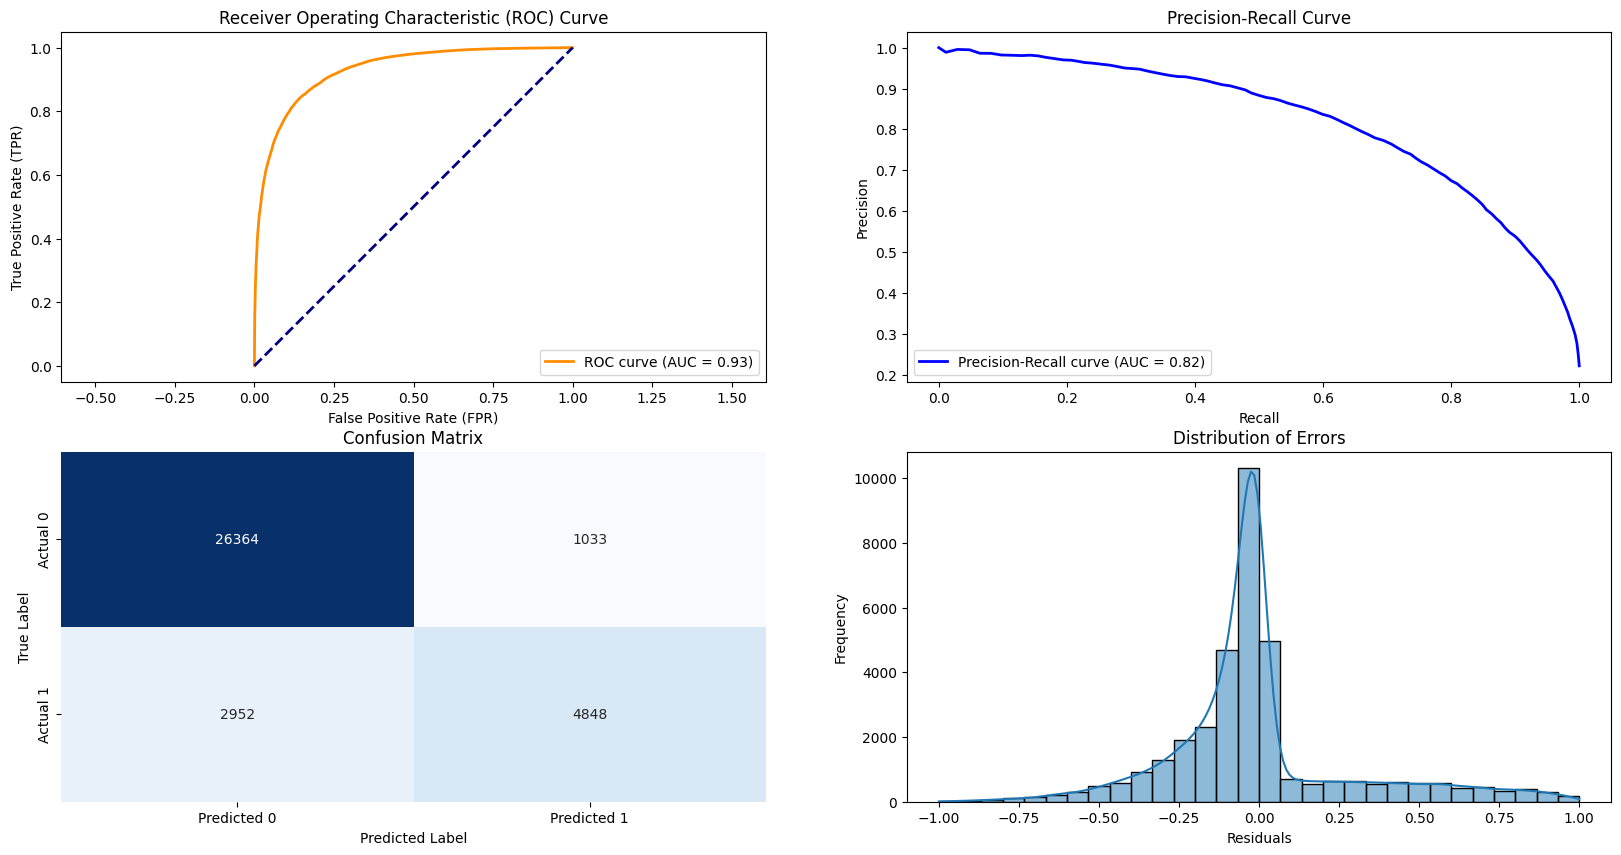

In [ ]:
model = Model(RandomForestClassifier(), name='RF No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [ ]:
metrics_RF_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_RF_no_resample.to_frame().T])
print(metrics_RF_no_resample)

Accuracy                                 0.857971
Precision                                0.729477
Recall                                   0.570769
F1-Score                                 0.640437
ROC AUC                                   0.88525
Confusion Matrix    [[25746, 1651], [3348, 4452]]
PR AUC                                   0.726767
Name                               DT No Resample
dtype: object


## KNN


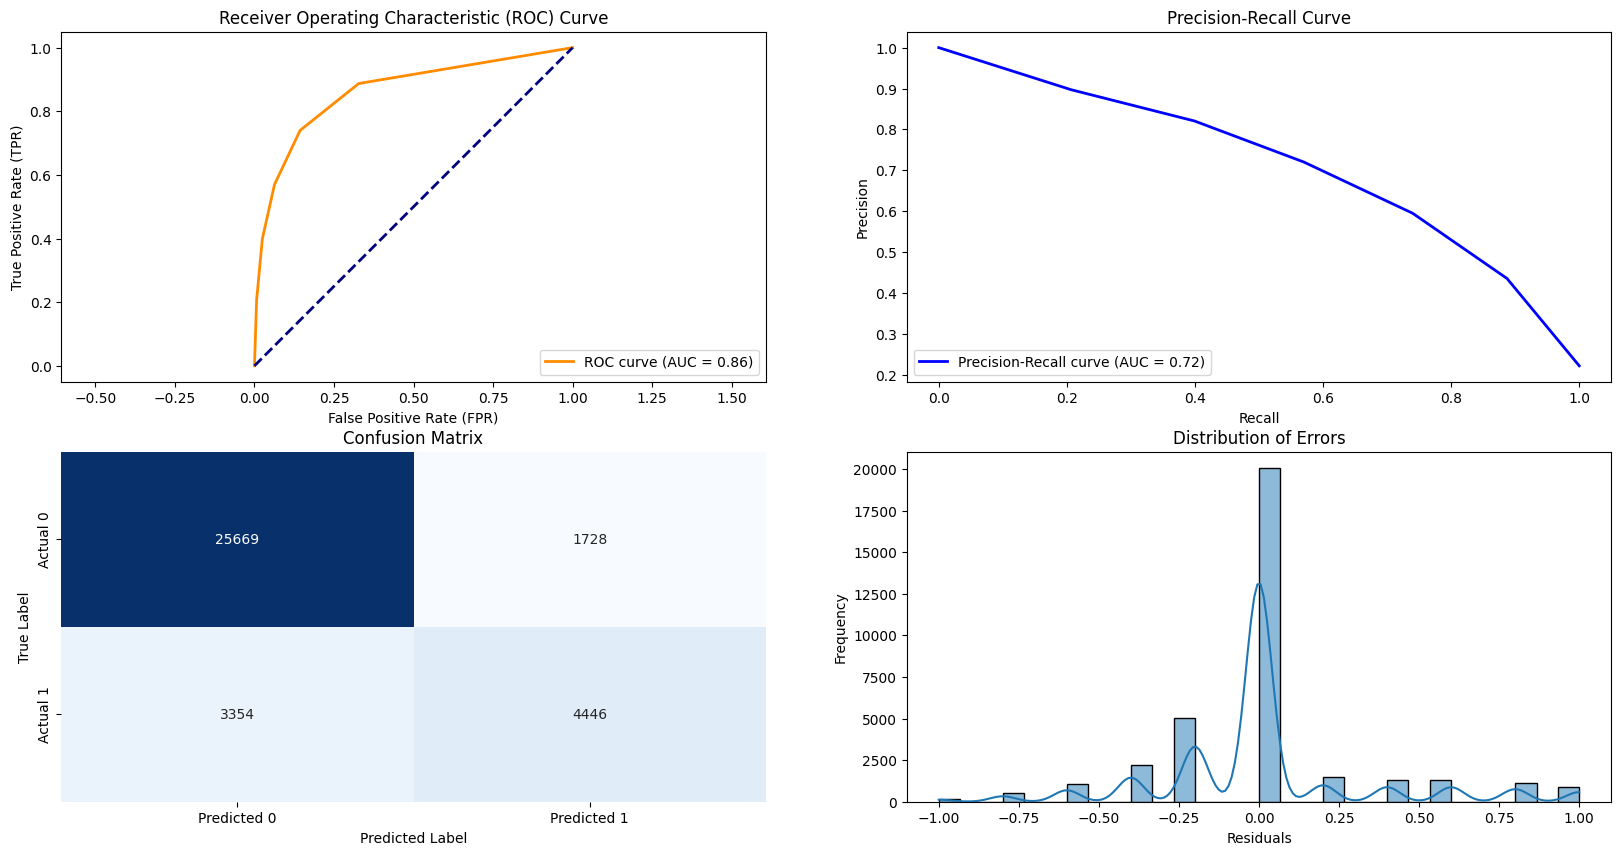

In [ ]:
model = Model(KNeighborsClassifier(),'KNN No Resample', scaled=True, resample = None)
model.fit()
model.visualize_metrics()

In [ ]:
metrics_KNN_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_KNN_no_resample.to_frame().T])
print(metrics_KNN_no_resample)

Accuracy                                 0.855613
Precision                                0.720117
Recall                                       0.57
F1-Score                                 0.636325
ROC AUC                                  0.861607
Confusion Matrix    [[25669, 1728], [3354, 4446]]
PR AUC                                   0.656541
Name                              KNN No Resample
dtype: object


## Neural Network

In [ ]:
from tensorflow.keras.optimizers import Adam
model = Sequential([
    Input(shape=[X_train.shape[1]]),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=100,
    epochs=200,
    shuffle = True,
    callbacks=[early_stopping]
)

Epoch 1/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - binary_accuracy: 0.8058 - loss: 0.4442 - val_binary_accuracy: 0.8514 - val_loss: 0.3410
Epoch 2/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - binary_accuracy: 0.8435 - loss: 0.3537 - val_binary_accuracy: 0.8575 - val_loss: 0.3310
Epoch 3/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - binary_accuracy: 0.8503 - loss: 0.3428 - val_binary_accuracy: 0.8591 - val_loss: 0.3265
Epoch 4/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - binary_accuracy: 0.8509 - loss: 0.3384 - val_binary_accuracy: 0.8618 - val_loss: 0.3233
Epoch 5/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - binary_accuracy: 0.8533 - loss: 0.3347 - val_binary_accuracy: 0.8628 - val_loss: 0.3214
Epoch 6/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - binary_accuracy: 0.8544 - loss: 0.3328 - val_binary_accuracy: 0.8640 - val_loss: 0.3198
Epoch 7/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - binary_accuracy: 0.8554 - loss: 0.3309 - val_binary_accuracy: 0.8649 - va

Best Validation Loss: 0.2106
Best Validation Accuracy: 0.9116


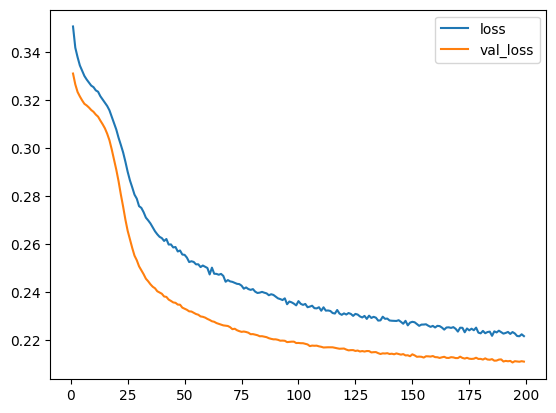

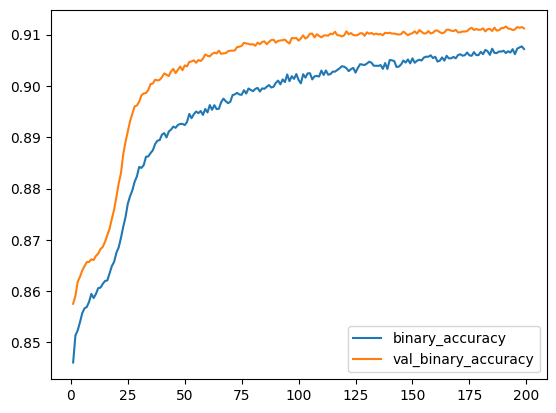

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_binary_accuracy'].max()))

In [ ]:
y_pred_prob_test = model.predict(X_test_scaled)
y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
print(acc_test)

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
0.9108730857743558


In [ ]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
'Name':'NN No Resample'
})
print(metrics_TF)
models_df = pd.concat([models_df, metrics_TF.to_frame().T])

Accuracy                                 0.910873
Precision                                0.832644
Recall                                   0.748205
F1-Score                                 0.788169
ROC AUC                                  0.957016
PR AUC                                   0.888796
Confusion Matrix    [[26224, 1173], [1964, 5836]]
Name                               NN No Resample
dtype: object


# Conclusion


In [ ]:
models_df_under.index = models_df_under.Name
models_df_under = models_df_under.drop('Name',axis=1)

## Comparison of metrics for different sampling methods

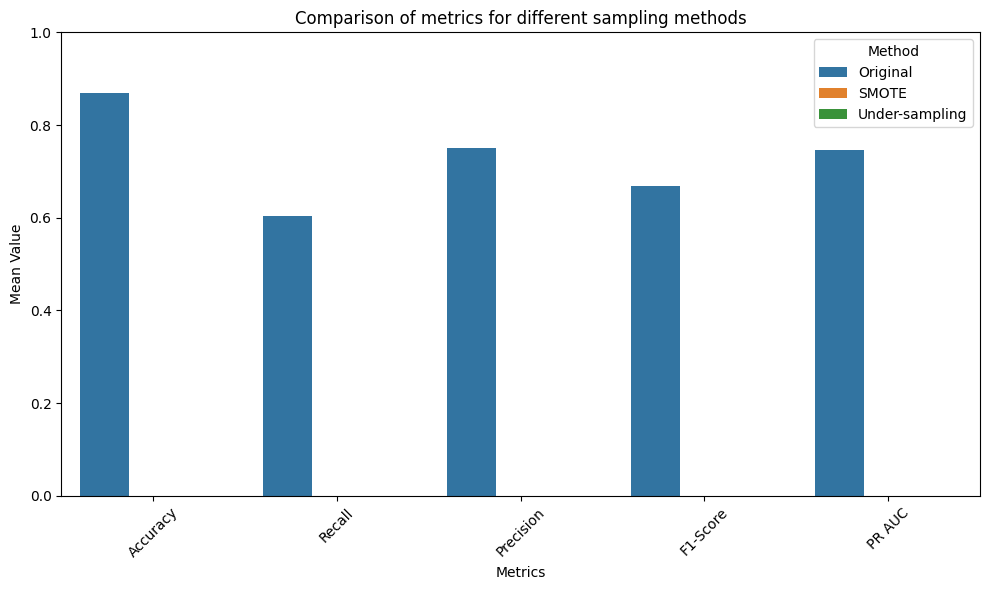

In [ ]:
metrics_long_df = metrics_df.melt(id_vars='Method', var_name='Metric', value_name='Value')
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Method', data=metrics_long_df)
plt.title('Comparison of metrics for different sampling methods')
plt.ylabel('Mean Value')
plt.xlabel('Metrics')
plt.ylim(0, 1)
plt.legend(title='Method')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()